In [1]:
import pandas_datareader.data as web
import pandas as pd
import numpy as np
import ta
from ta.volume import VolumeWeightedAveragePrice
from ta.trend import SMAIndicator
from ta.trend import EMAIndicator
from ta.volatility import AverageTrueRange
import time
import datetime
from datetime import date
from datetime import timedelta
from nsepy import get_history
import yfinance as yf

In [2]:
#Getting the list of tickers
df=pd.read_excel('Stock_List.xlsx', header= 1)
Tickers = df["Symbol"]
Tickers = Tickers.astype(str) + ".NS"

In [3]:
#Start Date for the analysis
start_date = "2010-01-01"
end_date = "2020-02-01"

In [4]:
def Add_Indicators(Data):
    EMA20  = EMAIndicator(close = Data["Open"], window = 20, fillna = True)
    EMA30  = EMAIndicator(close = Data["Low"], window = 30, fillna = True)
    EMA50  = EMAIndicator(close = Data["Close"], window = 50, fillna = True)
    EMA100 = EMAIndicator(close = Data["Close"], window = 100, fillna = True)
    EMA200 = EMAIndicator(close = Data["Close"], window = 200, fillna = True)
    ATR    = AverageTrueRange(high = Data["High"], low = Data["Low"], close = Data["Close"], window = 15, fillna = True)
    

    Data["EMA20"]  = EMA20.ema_indicator()
    Data["EMA30"]  = EMA30.ema_indicator()
    Data["EMA50"]  = EMA50.ema_indicator()
    Data["EMA100"] = EMA100.ema_indicator()
    Data["EMA200"] = EMA200.ema_indicator()
    Data["20_Days_EMA_High"] = Data["EMA20"].rolling(min_periods = 1, window = 20, center = False).max()
    Data["20_Days_EMA_Low"] = Data["EMA20"].rolling(min_periods = 1, window = 20, center = False).min()

    EMA20_20 = EMAIndicator(close = Data["EMA20"], window = 20, fillna = True)
    Data["EMA20_10"] = EMA20_20.ema_indicator()

    Data["ATR"] = ATR.average_true_range()

    return Data

In [5]:
#Checking conditions for trade
def check_weekly_conditions(Data_Weekly, j):

    flag = 1
    if(Data_Weekly["Close"][j] >=50):
        
         if(Data_Weekly["Volume"][j-1]>=300000):

            if(((Data_Weekly["Open"][j-1]-Data_Weekly["Close"][j-1]) < (Data_Weekly["Open"][j-2] - Data_Weekly["Close"][j-2]))):

                One_Half_Month = Data_Weekly[j-6:j]
                Avg_Green_Candles =One_Half_Month[One_Half_Month["Close"]>One_Half_Month["Open"]].Close.mean() - One_Half_Month[One_Half_Month["Close"]>One_Half_Month["Open"]].Open.mean()

                Avg_Red_Candles =One_Half_Month[One_Half_Month["Open"]>One_Half_Month["Close"]].Open.mean() - One_Half_Month[One_Half_Month["Open"]>One_Half_Month["Close"]].Close.mean()

                if(Avg_Green_Candles >= 1.3* Avg_Red_Candles):
                    if(Data_Weekly["EMA50"][j] > Data_Weekly["EMA100"][j]):
                        if(Data_Weekly["EMA100"][j] > Data_Weekly["EMA200"][j]):
                            return True, flag

    return False, flag


In [6]:
def check_daily_conditions(Data,j, Small_Cap):
    if(Data["Close"][j] >= 0.8*Data["High"][j-252:j].max()):
            if(Data["Close"][j] >= 1.75*Data["Low"][j-252:j].min()):
                if(Data["EMA50"][j] > Data["EMA100"][j]):
                        if(Data["EMA100"][j] > Data["EMA200"][j]):
                            if(Data["20_Days_EMA_High"][j] - Data["20_Days_EMA_Low"][j] >= 0.02 * Data["Close"][j]):
                                if(Data["EMA50"][j]<= Data["EMA30"][j]):
                                    if(Data["Close"][j]<=3*Data["Low"][j-252:j].min()):

                                        Index = Small_Cap[Small_Cap.index == Data.index[j]]
                                        if(Index.empty == True):
                                            Index = Small_Cap[Small_Cap.index == Data.index[j+1]]
                                        if(Index["EMA50"][0] > Index["EMA100"][0]):
                                            if(Index["Close"][0] > (Index["EMA20"][0] + Index["EMA30"][0])/2):
                                                
                                                return True
                        
    return False


In [7]:
#Checking Buying Conditions
def buying_conditions(Data,j):
    if(Data["Close"][j] > Data["EMA20"][j]):
        if(Data["Close"][j] - Data["Open"][j] >= 0.02 * Data["Open"][j]):
            if(Data["Close"][j] >= Data["Close"][j-1]):
                if(Data["Close"][j] - Data["EMA30"][j] <= 0.11 * Data["EMA30"][j]):
                    return True

    return False 

In [8]:
#Cheking Exit Conditions
def exit_conditions(Data, k, money_invested, Shares):
    if(Data["Close"][k]*Shares <= (1-0.0875) * money_invested):
        return True, "Loss"
    if(Data["Close"][k]*Shares >= 1.15 * money_invested):
        return True, "Profit"
    
    return False,0


In [9]:
def trailing_exit_conditions(Data, k, money_invested, Shares, trailing_stop_loss):
    
    stop_loss = Data["Close"][k] - 2 * Data["ATR"][k]
    final_stop_loss = max(stop_loss, trailing_stop_loss)

    if(Data["Close"][k] <= final_stop_loss):
        if(Data["Close"][k]*Shares > money_invested):
            return True, "Profit", final_stop_loss
        if(Data["Close"][k]* Shares <= money_invested):
            return True, "Loss", final_stop_loss

    return False,0, final_stop_loss        

In [10]:
%%time

Small_Cap = yf.download("^CRSLDX", start=start_date, end = end_date, interval= "1d", threads =True, group_by = "ticker")
Small_Cap = Small_Cap.drop("Adj Close", axis=1)
Small_Cap = Add_Indicators(Small_Cap)

Trades = pd.DataFrame(columns= ["Equity", "Day","Buy/Sell","Stock","Profit/Loss","Amount"])
Trade_Date = 0
equity = 1000000.0
Total_Profit = 0
Total_Loss = 0

for ticker in Tickers:
    #Mentioning initial amount
    print(ticker)
    equity = 1000000.0  #We are investing whole 10 lakh on a single stock for a month.
    money = equity
    money_invested = 0
    money_left = money - money_invested
    profit = 0
    loss = 0

    #Downloading Data

    Data = yf.download(ticker, start=start_date, end = end_date, period="1d", interval= "1d", threads =True, group_by = "ticker")

    if(Data.shape[0] < 252): #Not considering a stock if it isn't in the market for atleast a year
        continue
    if(Data["Close"][-1] < 50 ):
        continue

    Data_Weekly = yf.download(ticker, start=start_date, period="1wk", interval= "1wk", threads =True, group_by = "ticker")
    Data= Data.drop("Adj Close", axis=1)
    Data_Weekly= Data_Weekly.drop("Adj Close", axis=1)
    
    #Adding Indicators 
    Data = Add_Indicators(Data)
    Data_Weekly = Add_Indicators(Data_Weekly)

    temp = 0.1
    k = 0

    for j in range(252,Data.shape[0]): #Starting backtesting after a year from start date as we need 52 week high

        if (j < k):
            continue

        #Checking Daily Conditions
        if(check_daily_conditions(Data,j, Small_Cap)==True):

            mask = ((Data_Weekly.index >= Data.index[j]) & (Data_Weekly.index < Data.index[j] + timedelta(days =7)))
            dummy = Data_Weekly[mask]
            for z in range(52, Data_Weekly.shape[0]):
                if(Data_Weekly.index[z] == dummy.index[0]):
                    break
            Week_Start = z - 1    #Since the weekly data from yfinance shows data of the week ahead

            #Weekly conditions will be same for 4 consecutive days if the starting day is monday
            #Therefore to avoid checking conditions again for tuesday, wednesday, thursday and friday.
            if(temp!=Week_Start):
                temp = Week_Start
                #Checking Weekly Conditions
                passed_conditions, flag = check_weekly_conditions(Data_Weekly, Week_Start)

            if(passed_conditions == True):

                #Buying Phase
                if(buying_conditions(Data,j)==True):
                    Buy_Price = float(Data["Close"][j])
                    profit = 0
                    loss = 0
                    Shares = int(money/Buy_Price)
                    money_invested = Shares*Buy_Price
                    money_left = money - money_invested
                    Trade_Date = Data.index[j]
                    

                    #Appending the Trade in Equity DataFrame
                    new_row = {"Equity":equity, "Day": Trade_Date, "Buy/Sell":"Buy","Stock":ticker,"Profit/Loss":"Nill","Amount":0}
                    Trades = Trades.append(new_row, ignore_index = True)

                
                    #Selling Phase
                    for k in range(j+1, Data.shape[0]):
                        exit, trade = exit_conditions(Data, k, money_invested, Shares)

                        if(exit == True):
                            if(trade == "Profit"):
                                profit = Shares * Data["Close"][k] - money_invested
                                money_invested = 0
                                money_left = money_left + Shares * Data["Close"][k]
                                Trade_Date = Data.index[k]
                                equity = equity + profit

                                #Appending the Trade in Equity DataFrame
                                new_row = {"Equity":equity, "Day": Trade_Date, "Buy/Sell":"Sell","Stock":ticker,"Profit/Loss":"Profit","Amount":profit}
                                Trades = Trades.append(new_row, ignore_index = True)

                                profit = 0
                                break

                            if(trade == "Loss"):
                                loss =  money_invested - Shares * Data["Close"][k] 
                                money_invested = 0
                                money_left = money_left - Shares * Data["Close"][k]
                                Trade_Date = Data.index[k]
                                equity = equity - loss

                                #Appending the Trade in Equity DataFrame
                                new_row = {"Equity":equity, "Day": Trade_Date, "Buy/Sell":"Sell","Stock":ticker,"Profit/Loss":"Loss","Amount":loss}
                                Trades = Trades.append(new_row, ignore_index = True)

                                loss = 0
                                break

                                

************100%***********************]  1 of 1 completed
MAZDOCK.NS
[*********************100%***********************]  1 of 1 completed

1 Failed download:
- MAZDOCK.NS: Data doesn't exist for startDate = 1262284200, endDate = 1580495400
MOKSH.NS
[*********************100%***********************]  1 of 1 completed
MANINFRA.NS
[*********************100%***********************]  1 of 1 completed
JAGSNPHARM.NS
[*********************100%***********************]  1 of 1 completed
GENUSPOWER.NS
[*********************100%***********************]  1 of 1 completed
DEEPENR.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
GMDCLTD.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
DAAWAT.NS
[*********************100%***********************]  1 of 1 completed
HATHWAY.NS
[*********************100%********************

In [11]:
Trades

,Equity,Day,Buy/Sell,Stock,Profit/Loss,Amount
0,1.000000e+06,2014-03-31,Buy,INDOCO.NS,Nill,0
1,1.158242e+06,2014-05-30,Sell,INDOCO.NS,Profit,158242.0
2,1.158242e+06,2014-06-17,Buy,INDOCO.NS,Nill,0
3,1.375012e+06,2014-07-22,Sell,INDOCO.NS,Profit,216770.5
4,1.000000e+06,2014-06-24,Buy,GREAVESCOT.NS,Nill,0
...,...,...,...,...,...,...
138,9.080701e+05,2017-02-15,Sell,ARIES.NS,Loss,91929.946899
139,1.000000e+06,2017-05-12,Buy,NITINSPIN.NS,Nill,0
140,8.928060e+05,2017-05-22,Sell,NITINSPIN.NS,Loss,107194.005341
141,1.000000e+06,2017-07-12,Buy,INDIAGLYCO.NS,Nill,0


In [12]:
success_ratio = Trades[Trades["Profit/Loss"]=="Profit"].shape[0]/Trades[Trades["Buy/Sell"] == "Sell"].shape[0]
print("Success Ratio = ",success_ratio)

Success Ratio =  0.43661971830985913


In [13]:
#Trades.to_csv("Total_Trades", header=True)

In [14]:
max_profit = Trades[Trades["Profit/Loss"]=="Profit"].Amount.max()
print("Max Profit = ", max_profit)
max_loss= Trades[Trades["Profit/Loss"]=="Loss"].Amount.max()
print("Max Loss = ", max_loss)


Max Profit =  284277.6202697754
Max Loss =  212566.24310302734


In [15]:
Average_Success = Trades[Trades["Profit/Loss"]=="Profit"].Amount.mean()/Trades[Trades["Profit/Loss"]=="Loss"].Amount.mean()
print("Avg_Profit/Avg_Loss = ", Average_Success)

Avg_Profit/Avg_Loss =  1.7296993026377216


In [16]:
Total_Profit = Trades[Trades["Profit/Loss"]=="Profit"].Amount.sum() - Trades[Trades["Profit/Loss"]=="Loss"].Amount.sum()
print("Total Profit = ", Total_Profit)

Total Profit =  1461293.7094993591


In [17]:
Completed_Trades = Trades
Drop_List = np.array([])
for i in range(0, Completed_Trades.shape[0]):
    if(Completed_Trades["Buy/Sell"][i] == "Buy" and Completed_Trades["Buy/Sell"][i+1] != "Sell"):
        Drop_List = np.append(Drop_List,i)

Completed_Trades =Completed_Trades.drop(axis = 0, index = Drop_List)

Selling_Dates = pd.DataFrame(Completed_Trades[Completed_Trades["Buy/Sell"] == "Sell"]["Day"])
Selling_Dates = Selling_Dates.reset_index()
Buying_Dates =  pd.DataFrame(Completed_Trades[Completed_Trades["Buy/Sell"] == "Buy" ]["Day"])
Buying_Dates = Buying_Dates.reset_index()
Average_Trading_Days = (Selling_Dates["Day"] - Buying_Dates["Day"]).sum()/Selling_Dates.shape[0]
print("Average Trading Days = ", Average_Trading_Days)


Average Trading Days =  48 days 21:58:18.591549296


In [18]:
Average_Percent_Profit = Trades[Trades["Profit/Loss"]=="Profit"].Amount.mean()/1000000
Average_Percent_Loss = Trades[Trades["Profit/Loss"]=="Loss"].Amount.mean()/1000000
print("Average Percent Profit = ", Average_Percent_Profit)
print("Average Percent Loss = ", Average_Percent_Loss)

Average Percent Profit =  0.18557069181319208
Average Percent Loss =  0.10728494341773986


In [19]:
Max_Percent_Profit = max_profit/(1000000)
Max_Percent_Loss = max_loss/(1000000)
print("Max percent profit =", Max_Percent_Profit)
print("Max percent loss =", Max_Percent_Loss)

Max percent profit = 0.2842776202697754
Max percent loss = 0.21256624310302735


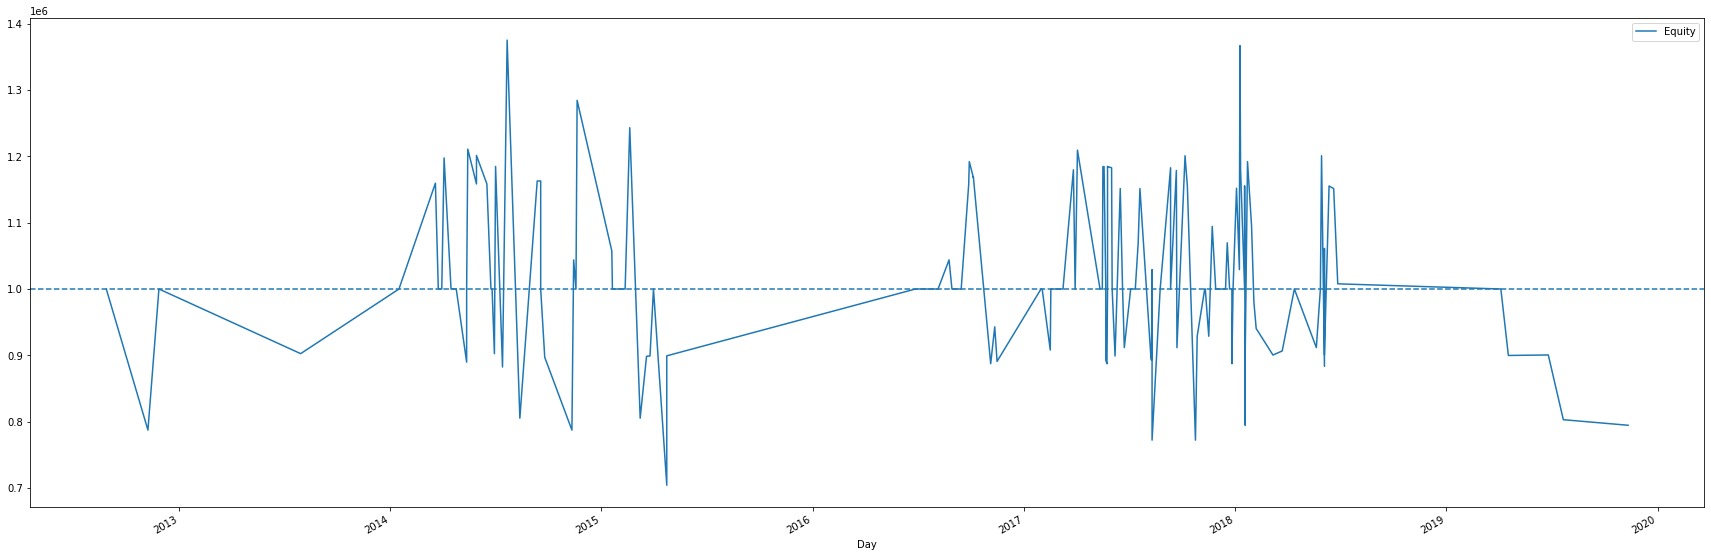

In [20]:
Plot = Trades.plot(y= "Equity", x = "Day", figsize=(30,10))
Plot.axhline(y = 1000000, linestyle = "--")

In [23]:
%%time
#If you want to try out the code on a sample of stocks

Small_Cap = yf.download("^CRSLDX", start=start_date, interval= "1d", threads =True, group_by = "ticker")
Small_Cap = Small_Cap.drop("Adj Close", axis=1)
Small_Cap =  Small_Cap.interpolate(method= "linear", axis = 1)
Small_Cap = Add_Indicators(Small_Cap)

Trades2 = pd.DataFrame(columns= ["Equity", "Day","Buy/Sell","Stock","Profit/Loss","Amount"])

equity = 1000000.0  #We are investing whole 10 on a single stock for a month if there are bullish candles present.
money = equity
money_invested = 0
money_left = money - money_invested
profit = 0
loss = 0

for limit in range(50):
    ticker = Tickers[limit]
    print(ticker)

    equity = 1000000.0  #We are investing whole 10 lakh on a single stock for a month.
    money = equity
    money_invested = 0
    money_left = money - money_invested
    profit = 0
    loss = 0


    Data = yf.download(ticker, start=start_date, end = end_date, period="1d", interval= "1d", threads =True, group_by = "ticker")

    if(Data.shape[0] < 252): #Not considering a stock if it isn't in the market for atleast a year
        continue
    if(Data["Close"][-1] < 50 ):
        continue

    Data_Weekly = yf.download(ticker, start=start_date, period="1wk", interval= "1wk", threads =True, group_by = "ticker")
    Data= Data.drop("Adj Close", axis=1)
    Data_Weekly= Data_Weekly.drop("Adj Close", axis=1)

    #Adding Indicators 
    Data = Add_Indicators(Data)
    Data_Weekly = Add_Indicators(Data_Weekly)
    
    temp = 0.1
    k = 0
    
    for j in range(252,Data.shape[0]-3):#Starting backtesting after a year from start date as we need 52 week high

        last_week_in_DF = False
        if (j < k):
            continue 
        

        #Checking Daily Conditions
        if(check_daily_conditions(Data,j, Small_Cap) == True):
            mask = ((Data_Weekly.index >= Data.index[j]) & (Data_Weekly.index < (Data.index[j] + timedelta(days =7))))
            dummy = Data_Weekly[mask]
            if(dummy.empty == True):
                Week_Start = Data_Weekly.shape[0]
                last_week_in_DF = True
            if(last_week_in_DF==False):    
                for z in range(52, Data_Weekly.shape[0]):
                    if(Data_Weekly.index[z] == dummy.index[0]):
                        break
                Week_Start = z - 1

            #Weekly conditions will be same for 4 consecutive days if the starting day is monday
            #Therefore to avoid checking conditions again for tuesday, wednesday, thursday and friday.
            if(temp!=Week_Start):
                temp = Week_Start
                #Checking Weekly Conditions
                passed_conditions, flag = check_weekly_conditions(Data_Weekly, Week_Start)

            if(passed_conditions == True):

                #Buying Phase
                if(buying_conditions(Data,j)==True):
                    Buy_Price = float(Data["Close"][j])
                    profit = 0
                    loss = 0
                    Shares = int(money/Buy_Price)
                    money_invested = Shares*Buy_Price
                    money_left = money - money_invested
                    Trade_Date = Data.index[j]
                    

                    #Appending the Trade in Equity DataFrame
                    new_row = {"Equity":equity, "Day": Trade_Date, "Buy/Sell":"Buy","Stock":ticker,"Profit/Loss":"Nill","Amount":0}
                    Trades2 = Trades2.append(new_row, ignore_index = True)


                    #Selling Phase
                    for k in range(j+1, Data.shape[0]):
                        exit, trade = exit_conditions(Data, k, money_invested, Shares)

                        if(exit == True):
                            if(trade == "Profit"):
                                profit = Shares * Data["Close"][k] - money_invested
                                money_invested = 0
                                money_left = money_left + Shares * Data["Close"][k]
                                Trade_Date = Data.index[k]
                                equity = equity + profit

                                #Appending the Trade in Equity DataFrame
                                new_row = {"Equity":equity, "Day": Trade_Date, "Buy/Sell":"Sell","Stock":ticker,"Profit/Loss":"Profit","Amount":profit}
                                Trades2 = Trades2.append(new_row, ignore_index = True)

                                profit = 0
                                break

                            if(trade == "Loss"):
                                loss =  money_invested - Shares * Data["Close"][k] 
                                money_invested = 0
                                money_left = money_left - Shares * Data["Close"][k]
                                Trade_Date = Data.index[k]
                                equity = equity - loss

                                #Appending the Trade in Equity DataFrame
                                new_row = {"Equity":equity, "Day": Trade_Date, "Buy/Sell":"Sell","Stock":ticker,"Profit/Loss":"Loss","Amount":loss}
                                Trades2 = Trades2.append(new_row, ignore_index = True)
                                loss = 0
                                break
                            
                   

[*********************100%***********************]  1 of 1 completed
ALICON.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
PANACHE.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ARCHIES.NS
[*********************100%***********************]  1 of 1 completed
JMA.NS
[*********************100%***********************]  1 of 1 completed
SILGO.NS
[*********************100%***********************]  1 of 1 completed
SARLAPOLY.NS
[*********************100%***********************]  1 of 1 completed
RKEC.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
OMAXE.NS
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
CREST.NS
[***************

In [22]:
Trades2

,Equity,Day,Buy/Sell,Stock,Profit/Loss,Amount
0,1.000000e+06,2014-03-31,Buy,INDOCO.NS,Nill,0
1,1.158242e+06,2014-05-30,Sell,INDOCO.NS,Profit,158242.0
2,1.158242e+06,2014-06-17,Buy,INDOCO.NS,Nill,0
3,1.375012e+06,2014-07-22,Sell,INDOCO.NS,Profit,216770.5
4,1.375012e+06,2021-06-21,Buy,INDOCO.NS,Nill,0
5,1.525481e+06,2021-07-02,Sell,INDOCO.NS,Profit,150468.314789
6,1.000000e+06,2014-06-24,Buy,GREAVESCOT.NS,Nill,0
7,1.184723e+06,2014-07-02,Sell,GREAVESCOT.NS,Profit,184723.0
8,1.000000e+06,2016-10-03,Buy,MUKANDLTD.NS,Nill,0
9,1.161905e+06,2016-10-25,Sell,MUKANDLTD.NS,Profit,161904.551559


In [23]:
success_ratio = Trades2[Trades2["Profit/Loss"]=="Profit"].shape[0]/Trades2[Trades2["Buy/Sell"] == "Sell"].shape[0]
print("Success Ratio = ",success_ratio)

Success Ratio =  0.7777777777777778
